# Bi-LSTM for NEEL Dataset (with GloVe)

### Author: Omer Waseem
#### Description: This Python notebook trains and evaluates a Bi-LSTM on the NEEL dataset using GloVe features

In [1]:
from dataprep import conll_words, neel_words
from helper import load_glove_dict, get_glove_vector, accuracy, entity_count, one_hot_encode, one_hot_decode
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, CuDNNLSTM, Bidirectional
from keras.callbacks import TensorBoard

/home/ow/miniconda3/envs/datamgt/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load GloVe features

In [2]:
g_file = '../glove/glove.twitter.27B.50d.txt'
g_dict = load_glove_dict(g_file)

### Load all data (training and test) to create a vocabulary dictionary

In [3]:
n_train_gs_file = './datasets/NEEL2006/training_neel.gs'
n_train_tsv_file = './datasets/NEEL2006/training.tsv'
n_test_gs_file = './datasets/NEEL2006/test_neel.gs'
n_test_tsv_file = './datasets/NEEL2006/test.tsv'

n_train_words, n_train_entity, n_train_errors = neel_words(n_train_gs_file, n_train_tsv_file)
n_test_words, n_test_entity, n_test_errors = neel_words(n_test_gs_file, n_test_tsv_file)

In [4]:
combined_words = n_train_words + n_test_words

In [5]:
print(len(n_train_words))
print(len(n_test_words))
print(len(combined_words))

69390
5408
74798


### Create char set, char dictionary and find length of maximum word for padding

In [6]:
char_set = set()
char_dict = {}
max_word_len = 0
for word in combined_words:
    if len(word) > max_word_len:
        max_word_len = len(word)
    for char in word:
        char_set.add(char)

for i, char in enumerate(char_set):
    char_dict[char] = int(i) + 1 # index 0 should not be used in vocab, since its used for masking

# ensure index 0 is not used
for key in char_dict.keys():
    if char_dict[key] == 0:
        raise KeyError('Error: index 0 is used with key: ', key)

print('Maximum word length:', max_word_len)

Maximum word length: 82


### Define hyperparameters

In [7]:
max_features = len(char_set) + 1
maxlen = 90
glove_len = 50
batch_size = 128
epochs = 10
drop_out = 0.5

### Convert training and test words into padded int vectors using char dictionary

In [8]:
def word2vec(words):
    out = []
    for word in words:
        temp = []
        for char in word:
            temp.append(char_dict[char])
        out.append(temp)
    return np.array(out)

In [9]:
train_words = sequence.pad_sequences(word2vec(n_train_words), maxlen=maxlen)
test_words = sequence.pad_sequences(word2vec(n_test_words), maxlen=maxlen)

### Append GolVe features

In [10]:
train_glove = []
for i in range(len(train_words)):
    train_glove.append(np.concatenate((train_words[i], get_glove_vector(g_dict, n_train_words[i]))))
train_glove = np.array(train_glove, dtype=np.float32)

test_glove = []
for i in range(len(test_words)):
    test_glove.append(np.concatenate((test_words[i], get_glove_vector(g_dict, n_test_words[i]))))
test_glove = np.array(test_glove, dtype=np.float32)

### One-Hot encode entities for training and test data

In [11]:
# one-hot formatting: [PER LOC ORG MISC O]
train_entities = one_hot_encode(n_train_entity)
test_entities = one_hot_encode(n_test_entity)

### Train Bi-LSTM model using Keras

In [12]:
model = Sequential()
model.add(Embedding(max_features, 480, input_length=maxlen + glove_len))
model.add(Dropout(drop_out))
model.add(Bidirectional(CuDNNLSTM(240, return_sequences = True)))
model.add(Bidirectional(CuDNNLSTM(80)))
model.add(Dense(5, activation='softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_glove, train_entities,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=[test_glove, test_entities],
          verbose=1)

Train on 69390 samples, validate on 5408 samples
Epoch 1/10
69390/69390 [==============================] - 46s 661us/step - loss: 0.5961 - acc: 0.8597 - val_loss: 0.7877 - val_acc: 0.8064
Epoch 2/10
69390/69390 [==============================] - 43s 619us/step - loss: 0.4887 - acc: 0.8651 - val_loss: 0.5454 - val_acc: 0.8214
Epoch 3/10
69390/69390 [==============================] - 43s 621us/step - loss: 0.3687 - acc: 0.8788 - val_loss: 0.5373 - val_acc: 0.8293
Epoch 4/10
69390/69390 [==============================] - 43s 621us/step - loss: 0.3393 - acc: 0.8897 - val_loss: 0.4851 - val_acc: 0.8554
Epoch 5/10
69390/69390 [==============================] - 43s 622us/step - loss: 0.3168 - acc: 0.8983 - val_loss: 0.4569 - val_acc: 0.8558
Epoch 6/10
69390/69390 [==============================] - 43s 622us/step - loss: 0.2977 - acc: 0.9051 - val_loss: 0.4653 - val_acc: 0.8327
Epoch 7/10
69390/69390 [==============================] - 43s 624us/step - loss: 0.2823 - acc: 0.9102 - val_loss: 0.4

### Plot accuracy and loss

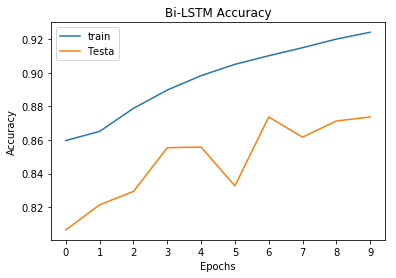

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Bi-LSTM Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.xticks(range(epochs))
plt.legend(['train', 'Testa'], loc='upper left')
plt.show()

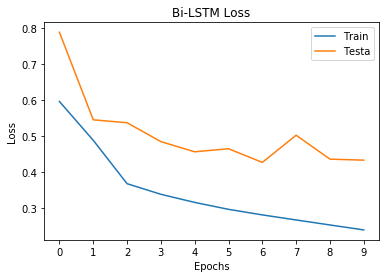

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Bi-LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks(range(epochs))
plt.legend(['Train', 'Testa'], loc='upper right')
plt.show()

### Predict test entities using trained model

#### Evaluation for test

In [15]:
test_pred = one_hot_decode(model.predict(test_glove))
accuracy(n_test_entity, test_pred)

accuracy = 4725 / 5408 = 0.873706


In [16]:
precision_recall_fscore_support(n_test_entity, test_pred)

(array([0.3       , 0.63307494, 0.91186513, 0.45454545, 0.72608696]),
 array([0.40540541, 0.50619835, 0.97982114, 0.17123288, 0.43947368]),
 array([0.34482759, 0.56257176, 0.94462253, 0.24875622, 0.54754098]),
 array([  37,  484, 4361,  146,  380]))

In [17]:
entity_count(n_test_entity)

ORG: 146
PER: 380
LOC: 37
MISC: 484
O: 4361
